In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import spatialdata as sd
import torch
import random
import pickle
import re
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import timm
import matplotlib.patches as patches
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
import datetime
from copy import deepcopy
from tqdm import tqdm
from IPython.display import HTML
import base64


import importlib
import models
importlib.reload(models)
from models import CNNPlusLinear, trainer
from eval import compute_r2, compute_pearsonr

# hugginface
from dotenv import load_dotenv
from huggingface_hub import login
load_dotenv(dotenv_path=os.path.expanduser('~/hl/.gutinstinct.env'))
api_token = os.getenv("API_TOKEN")
login(token=api_token)

SEED = 209
DATA_PATH = 'data/processed'

# Decision to change our prediction task
Originally, as defined by "crunch 1" of the hackathon challenge from which we took the data from, the goal was to predict the expression level of 460 genes at the single cell level, "test cells" were given which we can provide prediction and compare against a benchmark on the competition website (similar to our kaggle challenges), while actual performance is evaluated on a held out set. With this goal in mind, during the course of MS3 and MS4, we consistantly observed that our model was unable to 1) extract meaningful features for the task and 2) unable to learn, which we concluded from the following observations
- We began by using mse loss, which is standard for this task. During training, models reduced loss by at most 1e-3, and plateaus at 5th epoch
- We couldn't get our models to overfit
- Using a distributional loss in addition to the mse loss does not help the model learn
- In all cases (ResNet50 + MLP, UNI2 + MLP), we consistantly observed a negative R2, and a pearson / spearman close to 0

For clarity and conciseness we omit the prior results. After receiving guidance and feedback from Tong Ding during our meeting on 5/7, we decided to change our task slightly. The motivation is summarized as below:
- The single cell transcriptome is an inherently hard task. High sparsity holds both true biological signal and noise.
- Edge cases could collude with learning. Consider the case where two neighboring cells with completely different cell states sharing almost identical patch information. 

As a result, the report from this point on focuses on predicting the average expression of all cells in a given patch.

# Modeling Approach

For this project, we aim to predict patch level gene expression from local histology by systematically investigating the influence of surrounding morphological context. Our pipeline begins with patchifying the whole-slide images (WSIs) into square patches. We aim to experiment with varying levels of contextual information, but for the purposes of this notebook we are going to start with 200x200 pixels.

### Overview: Patch-level embedding and prediction
As ViTs are flexible to input size, we will use pretrained pathology-specific ViT model — specifically UNI-2 — for patch embedding. UNI, based on ViT-Large, outputs 1024-dimensional embeddings; and UNI-2, based on ViT-Giant, outputs 1536-dimensional embeddings. In the patch-level approach, each entire resized patch (regardless of its original extracted size) was processed through the ViT to yield a single vector embedding representing the patch as a whole.

For predicting gene expression from these patch embeddings, we used a shallow multi-layer perceptron (MLP) to model the relationship between patch embedding and the corresponding cell's gene expression profile. A typical MLP architecture will project the input embedding (e.g., 768, 1024, or 1536 dimensions) through two or three hidden layers with ReLU activations. For example, the network may consist of a 512-unit layer followed by a 256-unit layer before outputting predictions for 460 target genes. The models minimize mean squared error (MSE) between predicted and log1p-transformed true expression values, stabilizing variance due to the heavy-tailed distribution of RNA counts.

Cells will be randomly split into training-validation-testing sets to ensure fair evaluation without information leakage. Model performance will be assessed primarily via Pearson correlation coefficients and R2 between predicted and observed expression profiles. For all model training we used pytorch for maximized customizability

### Patching (Data processing)
We have a total of 8 WSI images with paired single cell expression data. One of them contained no cell ids (DC1, supposedly held out). For each of the remaining 7 slides, we first divide the image into 224z224 pixel large patches. For each patch, we record a list of cell ids whose centroid is located within the patch boundary. We then took the patch boundary to crop out the corresponding image patches and saved as a PIL image, while at the same time taking the list of cell ids for each patch to obtain an average expression for each of the 460 genes across all cells witin the patch. These steps are done outside of this notebook using a script located at [src/data/patch_process.py](https://github.com/harrlol/gutinstinct/blob/main/src/data/patch_process.py), with the resulting data object saved as a pickle file for each image, which we load into the environment below. 

In [9]:
# load in pkl files
all_patches = []
for filename in os.listdir(osp.expanduser(DATA_PATH)):
    if filename.endswith('.pkl'):
        image_id = re.sub(r'^patch_to_expr_', '', os.path.splitext(filename)[0])
        filepath = os.path.join(osp.expanduser(DATA_PATH), filename)
        with open(filepath, 'rb') as f:
            patch_list = pickle.load(f)
            for patch in patch_list:
                patch['image_id'] = image_id
                all_patches.append(patch)

### Load data, split

We proceed with a train:val:test = 7:1.5:1.5 split. We manually stratify by image_id because we expect slightly different pathological features present in each slide and therefore potentially different disease mechanism at play. This means that the model should be able to learn and generalize better as it benefits from this controlled diversity. We unfortunately did not do an ablation study on the straitification, which would be an important future direction.

In [10]:
random.seed(SEED)
patch_train, patch_val, patch_test = [], [], []
expr_train, expr_val, expr_test = [], [], []

# set up splits
# we will stratify by image_id
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15

image_id_to_patches = {}
for patch in all_patches:
    image_id = patch['image_id']
    if image_id not in image_id_to_patches:
            image_id_to_patches[image_id] = []
    image_id_to_patches[image_id].append(patch)

for patch_list in image_id_to_patches.values():
    # get total patch number for current image_id
    n = len(patch_list)

    # shuffle the patches
    random.shuffle(patch_list)

    # get the split indices
    n_train = int(n * train_prop)
    n_val = int(n * val_prop)
    n_test = n - n_train - n_val

    train = patch_list[:n_train]
    val = patch_list[n_train:n_train + n_val]
    test = patch_list[n_train + n_val:]

    # Separate each into X (pil) and y (expr)
    patch_train.extend([p['pil'] for p in train])
    expr_train.extend([p['expr'] for p in train])

    patch_val.extend([p['pil'] for p in val])
    expr_val.extend([p['expr'] for p in val])

    patch_test.extend([p['pil'] for p in test])
    expr_test.extend([p['expr'] for p in test])

print(f"Train: {len(patch_train)}, Val: {len(patch_val)}, Test: {len(patch_test)}")

Train: 12597, Val: 2697, Test: 2707


### Brief EDA

Below we show some plots and stats for image UC6_I after the above processing steps. Trends are comparable across images. 

Processing ~/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr

HE Nucleus Mask of dimension: (20000, 20992)

Number of cells in this slide: 308924

Number of patches: 3703

Patch size: 224

Minimum number of cells in a patch: 1

Maximum number of cells in a patch: 523

Average number of cells in a patch: 83.425

Number of patches with valid images: 3703

Max average expression: 0.11787694692611694

Min average expression: 0.04020948335528374

Deleted 462 patches with no cells containing expression information

Number of remaining patches (which has valid expression data): 3241

Number of patches with at least 10 cells: 46

Number of patches with at least 10 cells: 2459

Number of patches with at least 100 cells: 827

Finished processing ~/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr


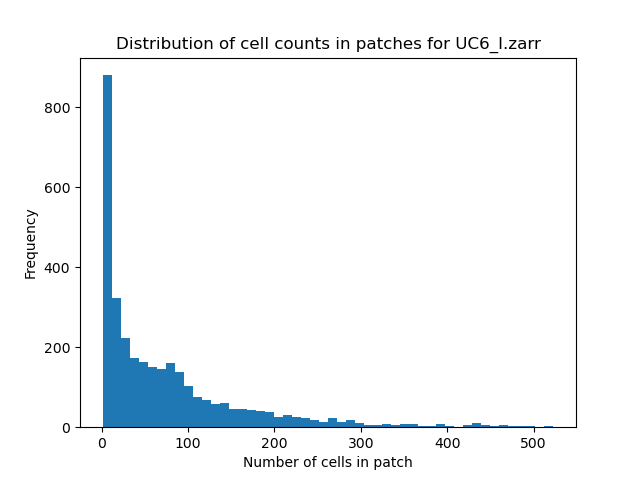

In [31]:
## cell_counts_per_patch_UC6_I.zarr.png
with open(osp.expanduser("~/hl/gutinstinct/data/plots/cell_counts_per_patch_UC6_I.zarr.png"), "rb") as f:
    encoded = base64.b64encode(f.read()).decode("utf-8")

HTML(f'<img src="data:image/png;base64,{encoded}">')



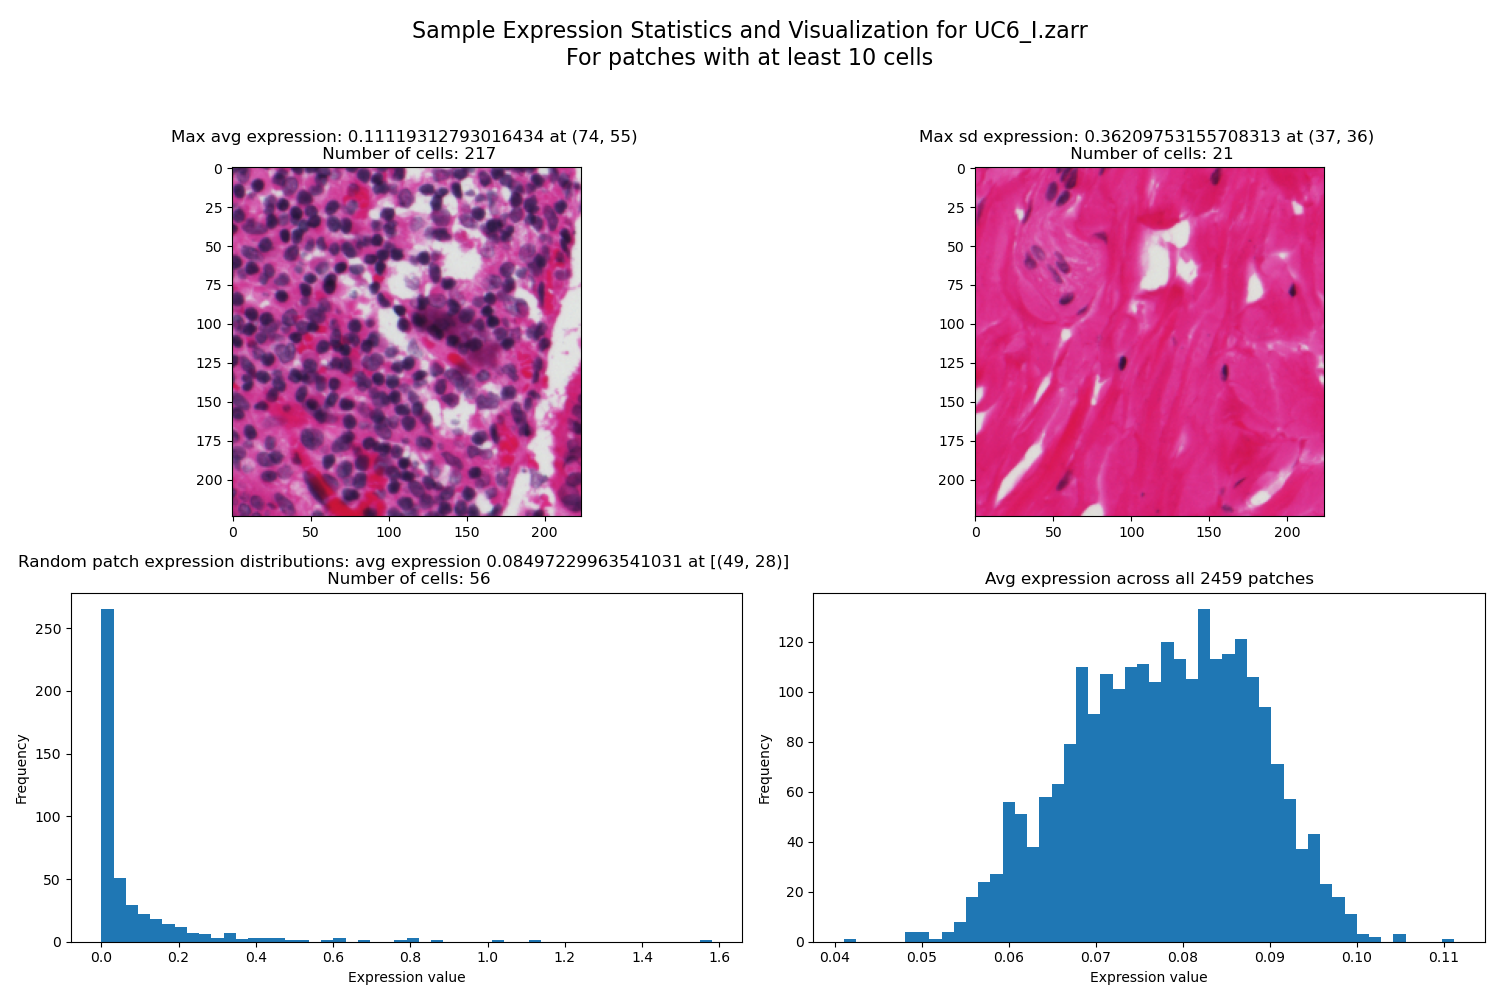

In [32]:
## sample_expression_viz_UC6_I.zarr.png
with open(osp.expanduser("~/hl/gutinstinct/data/plots/sample_expression_viz_UC6_I.zarr.png"), "rb") as f:
    encoded = base64.b64encode(f.read()).decode("utf-8")

HTML(f'<img src="data:image/png;base64,{encoded}">')



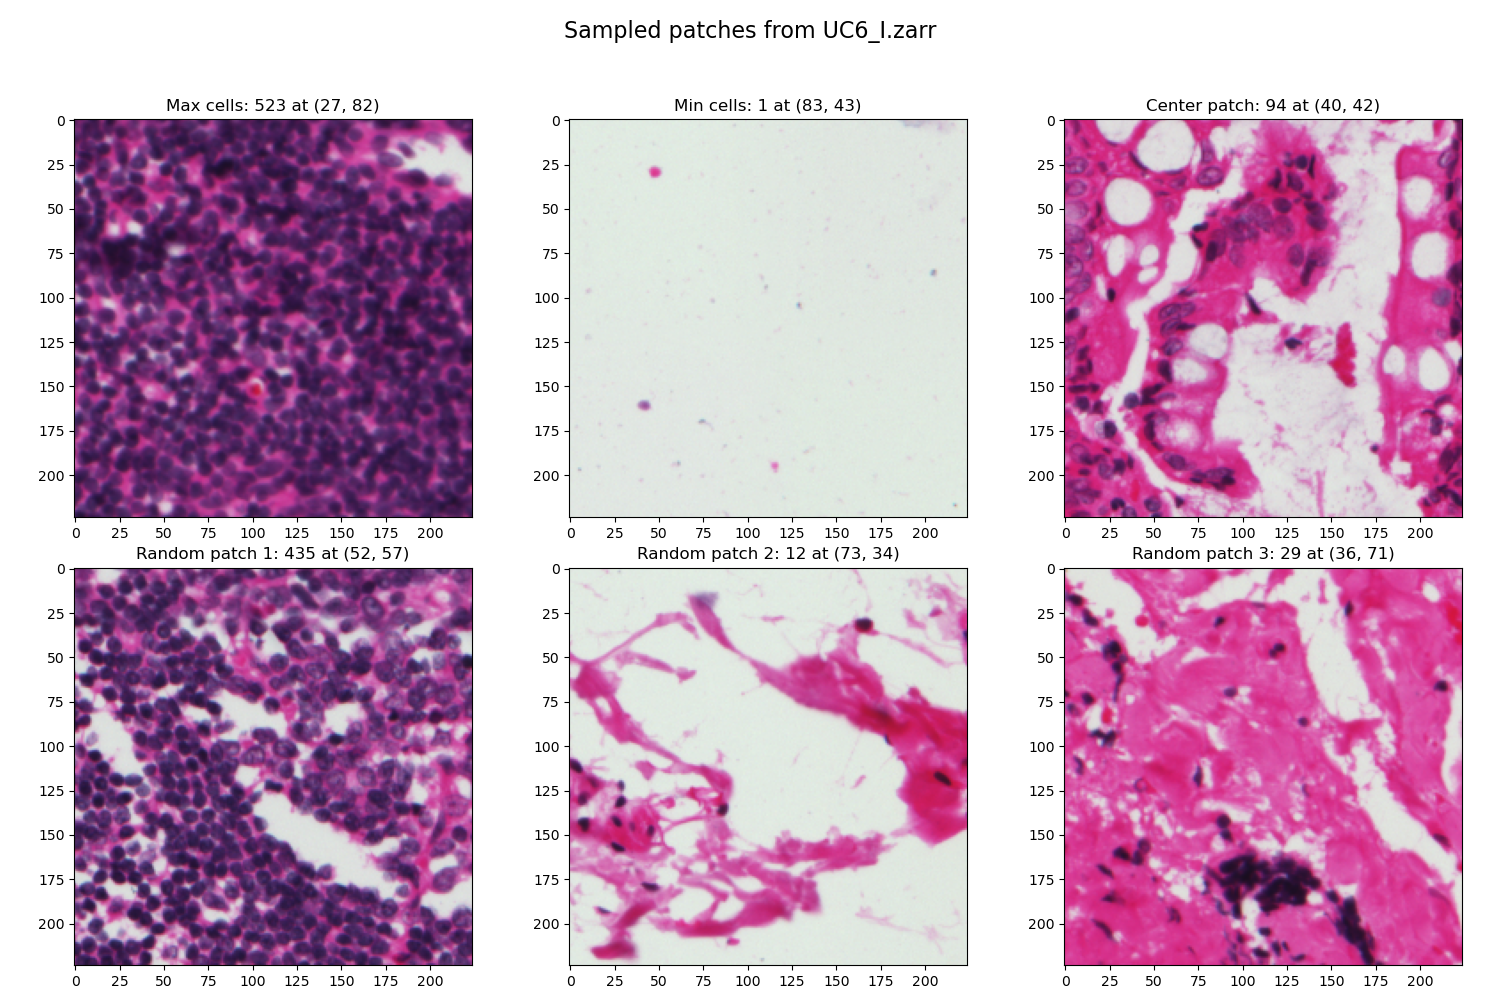

In [34]:
## sample_patches_viz_UC6_I.zarr.png
with open(osp.expanduser("~/hl/gutinstinct/data/plots/sample_patches_viz_UC6_I.zarr.png"), "rb") as f:
    encoded = base64.b64encode(f.read()).decode("utf-8")

HTML(f'<img src="data:image/png;base64,{encoded}">')

### Training setup

For all model training, we use AdamW with 0.001 weight decay to avoid overfitting and increase generalizability. While the latter is not a particular big problem in comparison (thanks to our stratification), during initial training we did observe significant overfitting. In addition, we also added numerous dropouts in the baseline for the same purpose -- and for later UNI + MLP setups as well, where applicable. For all trianing, we used 100 epochs with ealry stopping with patience=10 (5 for finetuning because of time constraint), adaptable learning rate with initial at 1e-3. Early stopping allows us to automatically retrieve the best performing model before it starts to overfit by monitoring validation loss, and scheduler allows us to gradually decrease learning rate as we approach a minima to avoid overshooting. In addition to mse loss, we also use R2 and pearson to evaluate our model performance. These two metrics are commonly used by the field for expression prediction. Intuitively, it compares "how far off is the predicted cell state to the ground truth cell state" by placing the two inside a shared high dimensional space and calculating the distance between the two points, and is therefore suitable for our task here. 

### Baseline: CNN + Linear

For our baseline we used a CNN architecture with a single linear layer as its prediction head. The mode is 3 layers deep in CNN, and detailed configs of the model is recorded [here](https://github.com/harrlol/gutinstinct/blob/main/src/models/baseline.py) \

Below, we create data loaders to feed into this model, using torch vision's transform for PIL image normalization / scaling, and common pipeline for tensor creation and dataloaders. 

In [11]:
# process images, pair with expression vectors
transform = transforms.ToTensor()

# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0253, Val Loss: 0.0236, R2: 0.4763, Pearson: 0.7061
Epoch 2/100, Train Loss: 0.0208, Val Loss: 0.0221, R2: 0.5191, Pearson: 0.7274
Epoch 3/100, Train Loss: 0.0200, Val Loss: 0.0212, R2: 0.5448, Pearson: 0.7431
Epoch 4/100, Train Loss: 0.0196, Val Loss: 0.0208, R2: 0.5565, Pearson: 0.7480
Epoch 5/100, Train Loss: 0.0194, Val Loss: 0.0207, R2: 0.5576, Pearson: 0.7521
Epoch 6/100, Train Loss: 0.0191, Val Loss: 0.0201, R2: 0.5738, Pearson: 0.7577
Epoch 7/100, Train Loss: 0.0189, Val Loss: 0.0199, R2: 0.5781, Pearson: 0.7610
Epoch 8/100, Train Loss: 0.0187, Val Loss: 0.0198, R2: 0.5808, Pearson: 0.7628
Epoch 9/100, Train Loss: 0.0187, Val Loss: 0.0202, R2: 0.5704, Pearson: 0.7609
Epoch 10/100, Train Loss: 0.0185, Val Loss: 0.0200, R2: 0.5735, Pearson: 0.7631
Epoch 11/100, Train Loss: 0.0185, Val Loss: 0.0200, R2: 0.5758, Pearson: 0.7630
Epoch 12/100, Train Loss: 0.0183, Val Loss: 0.0195, R2: 0.5863, Pearson: 0.7670
Epoch 13/100, Train Loss: 0.0182, Val Loss: 0.019

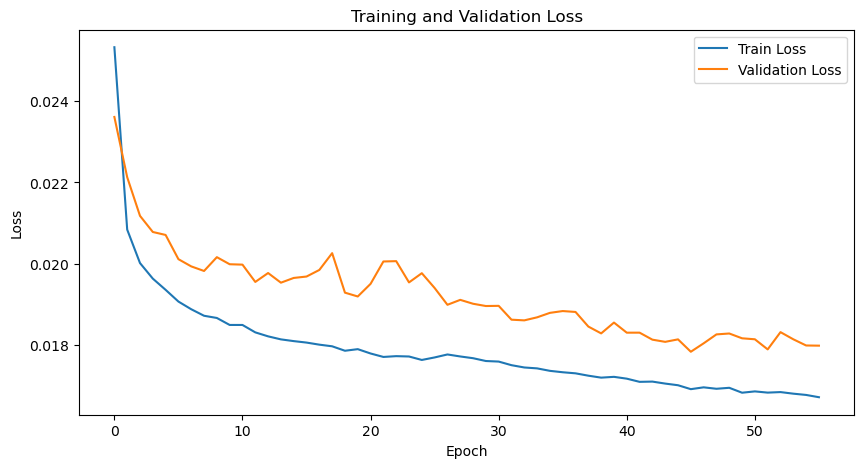

In [5]:
# train the model
model_baseline = CNNPlusLinear()

model_baseline, metrics_baseline = trainer.train_model(
    model_baseline,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='baseline_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)

In [43]:
# evaluate baseline on test set
model_baseline.eval().to('cuda')
running_test_loss = 0.0
y_preds = []
y_trues = []
criterion = nn.MSELoss()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_baseline(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

metrics_baseline['test_loss'] = test_loss
metrics_baseline['test_r2'] = r2_score
metrics_baseline['test_pearson'] = pearson_score

#Test Loss: 0.0173, R2: 0.6311, Pearson: 0.7948

Test Loss: 0.0173, R2: 0.6311, Pearson: 0.7948


### UNI Baseline

We thought to investigate whether a visual transformer called UNI, trained specifically on extracting useful features in H&E images, could produce useful features for our prediction task here. Notably, UNI was trained exclusively on image reconstruction tasks and distillation tasks, both in the imaging domain and is quite dissimilar to what we are doing here which is predicting another data modality. Theoretically, it would've internalized enough means to extract representations of an image to excel at a transfer learning task. Indeed, for this baseline section, we are evaluating UNI's zero shot ability at predicting gene expression using image features

For the uni model we took their default configurations on their [github repo](https://github.com/mahmoodlab/UNI)

In [12]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
model_uni.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [13]:
# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# get features with uni
with torch.no_grad():
    patch_tensors_train = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_train]
    patch_tensors_val = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_val]
    patch_tensors_test = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Here we pair an additional funneling MLP to transform the UNI-extracted features into the 460 gene expression predictions. This was decided after a little bit of experimenting with numbers of MLP layers and shape of the MLP, and eventually settled down on the architecture shown below. Dropout was added to mitigate overfitting.

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0185, Val Loss: 0.0174, R2: 0.6432, Pearson: 0.8026
Epoch 2/100, Train Loss: 0.0151, Val Loss: 0.0172, R2: 0.6462, Pearson: 0.8069
Epoch 3/100, Train Loss: 0.0146, Val Loss: 0.0171, R2: 0.6483, Pearson: 0.8092
Epoch 4/100, Train Loss: 0.0144, Val Loss: 0.0167, R2: 0.6615, Pearson: 0.8133
Epoch 5/100, Train Loss: 0.0142, Val Loss: 0.0165, R2: 0.6683, Pearson: 0.8195
Epoch 6/100, Train Loss: 0.0141, Val Loss: 0.0164, R2: 0.6685, Pearson: 0.8186
Epoch 7/100, Train Loss: 0.0139, Val Loss: 0.0164, R2: 0.6715, Pearson: 0.8206
Epoch 8/100, Train Loss: 0.0138, Val Loss: 0.0162, R2: 0.6745, Pearson: 0.8223
Epoch 9/100, Train Loss: 0.0138, Val Loss: 0.0162, R2: 0.6767, Pearson: 0.8232
Epoch 10/100, Train Loss: 0.0136, Val Loss: 0.0161, R2: 0.6790, Pearson: 0.8245
Epoch 11/100, Train Loss: 0.0135, Val Loss: 0.0160, R2: 0.6791, Pearson: 0.8258
Epoch 12/100, Train Loss: 0.0135, Val Loss: 0.0161, R2: 0.6815, Pearson: 0.8255
Epoch 13/100, Train Loss: 0.0134, Val Loss: 0.015

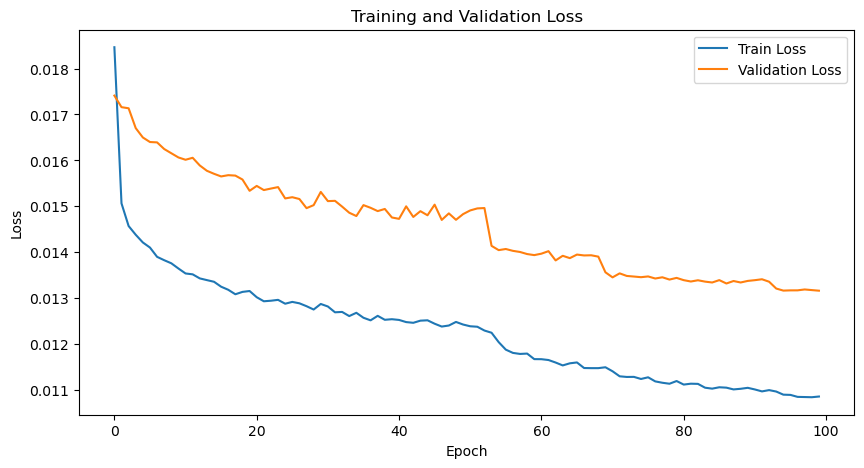

In [14]:
# train the model
model_uni_baseline = nn.Sequential(
    nn.Linear(1536, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 460),
).to('cuda')

model_uni_baseline, metrics_uni_baseline = trainer.train_model(
    model_uni_baseline,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='uni_baseline_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)

In [15]:
# evaluate baseline on test set
model_uni_baseline.eval().to('cuda')
criterion = nn.MSELoss()
running_test_loss = 0.0
y_preds = []
y_trues = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_uni_baseline(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

metrics_uni_baseline['test_loss'] = test_loss
metrics_uni_baseline['test_r2'] = r2_score
metrics_uni_baseline['test_pearson'] = pearson_score

#Test Loss: 0.0133, R2: 0.7394, Pearson: 0.8577

Test Loss: 0.0124, R2: 0.7553, Pearson: 0.8677


### Finetuning UNI

Even though the UNI as it is showed strong performance off the bat, we were interested in seeing if we could further improve it. The idea is that the original task was entirely at the phenotypical / image level, not collecting information for the goal of predicting expression, so maybe the features extracted in the last layer aren't quite exactly what we need to get good expression prediction. So, below we finetune the last two blocks of the ViT (unfreeze the last two blocks of the ViT, freezing the rest) on our expression prediction task by connecting the output from the last block to a simple MLP prediction head that outputs the 460 gene expressions. Hopefully, we can "rewire" the model to learn attentions that are more relevant to our prediction task here. 

In [11]:
# finetune uni
import torch.nn as nn

class FinetunedUni(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base = base_model
        self.head = nn.Linear(base_model.num_features, num_classes)
    
    def forward(self, x):
        x = self.base(x)
        x = self.head(x)
        return x

# instantiate
model_finetune = FinetunedUni(model_uni, num_classes=460).to('cuda')
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_finetune))
model_finetune.train()

# let's unfreeze the last two blocks of the uni model
for name, param in model_finetune.named_parameters():
    if any(f"blocks.{i}" in name for i in range(22, 24)):
        param.requires_grad = True
    else:
        param.requires_grad = False

# check the number of trainable parameters
num_trainable = sum(p.numel() for p in model_finetune.parameters() if p.requires_grad)
num_total = sum(p.numel() for p in model_finetune.parameters())
print(f"Number of trainable parameters: {num_trainable} out of {num_total} total parameters")

Number of trainable parameters: 56673280 out of 685598668 total parameters


In [12]:
# remake dataloaders for finetuning
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0145, Val Loss: 0.0167, R2: 0.6625, Pearson: 0.8123
Epoch 2/100, Train Loss: 0.0129, Val Loss: 0.0164, R2: 0.6703, Pearson: 0.8177
Epoch 3/100, Train Loss: 0.0124, Val Loss: 0.0164, R2: 0.6699, Pearson: 0.8198
Epoch 4/100, Train Loss: 0.0121, Val Loss: 0.0163, R2: 0.6734, Pearson: 0.8207
Epoch 5/100, Train Loss: 0.0117, Val Loss: 0.0164, R2: 0.6729, Pearson: 0.8210
Epoch 6/100, Train Loss: 0.0114, Val Loss: 0.0165, R2: 0.6719, Pearson: 0.8202
Epoch 7/100, Train Loss: 0.0110, Val Loss: 0.0164, R2: 0.6745, Pearson: 0.8226
Epoch 8/100, Train Loss: 0.0107, Val Loss: 0.0163, R2: 0.6780, Pearson: 0.8232
Epoch 9/100, Train Loss: 0.0103, Val Loss: 0.0162, R2: 0.6813, Pearson: 0.8249
Epoch 10/100, Train Loss: 0.0098, Val Loss: 0.0159, R2: 0.6880, Pearson: 0.8281
Epoch 11/100, Train Loss: 0.0094, Val Loss: 0.0166, R2: 0.6757, Pearson: 0.8236
Epoch 12/100, Train Loss: 0.0091, Val Loss: 0.0162, R2: 0.6850, Pearson: 0.8270
Epoch 13/100, Train Loss: 0.0087, Val Loss: 0.016

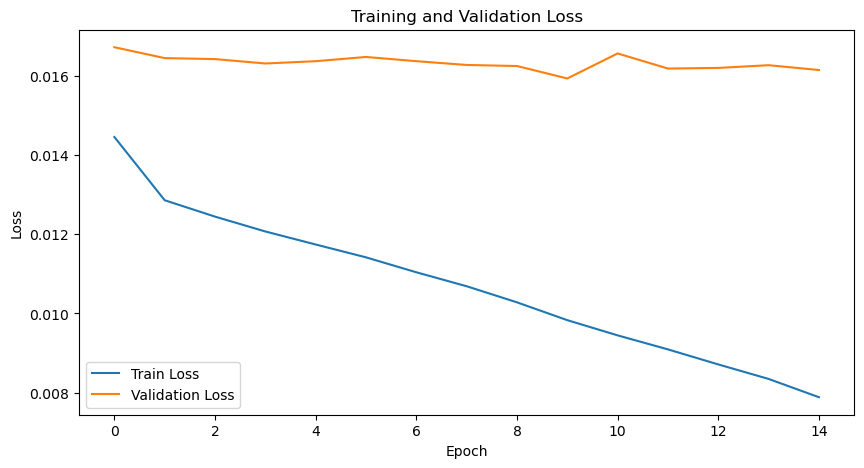

In [13]:
# config
n_epoch = 100
optimizer = optim.Adam(model_finetune.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()

# early stopping
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses, val_losses = [], []
r2_scores, pearson_scores = [], []

for epoch in range(n_epoch):
    # train
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model_finetune(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # validate
    model_finetune.eval()
    running_val_loss = 0.0
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
            y_pred = model_finetune(x_batch)
            loss = criterion(y_pred, y_batch)
            running_val_loss += loss.item()

            y_preds.append(y_pred.cpu().numpy())
            y_trues.append(y_batch.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

    # metrics
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    r2_scores.append(r2_score)
    pearson_scores.append(pearson_score)

    # log and es
    print(f"Epoch {epoch+1}/{n_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model_finetune.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

if best_model_state is not None:
    model_finetune.load_state_dict(best_model_state)
    print("Best model restored.")

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("finetuning_uni_loss_plot.png")
plt.show()

In [14]:
# save the model
torch.save(model_finetune.state_dict(), 'finetuned_uni_model.pth')

# load the model
model_finetune.load_state_dict(torch.load('finetuned_uni_model.pth'))
model_finetune = model_finetune.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_finetune.base.pretrained_cfg, model=model_finetune.base))
model_finetune.eval()

FinetunedUni(
  (base): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): GluMlp(
          (fc1): Linear(in_features=1536, out_features=8192, bias=True)
          (act): SiLU()
      

### Finetuned UNI

In this section we put our finetuned UNI to the test, and see if it can indeed outperform the baseline UNI, or even our baseline CNN, for that matter.

In [15]:
# we now use the finetuned model to get features
# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# get features with uni
with torch.no_grad():
    patch_tensors_train = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_train]
    patch_tensors_val = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_val]
    patch_tensors_test = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0177, Val Loss: 0.0171, R2: 0.6513, Pearson: 0.8067
Epoch 2/100, Train Loss: 0.0141, Val Loss: 0.0168, R2: 0.6620, Pearson: 0.8138
Epoch 3/100, Train Loss: 0.0138, Val Loss: 0.0168, R2: 0.6596, Pearson: 0.8137
Epoch 4/100, Train Loss: 0.0135, Val Loss: 0.0166, R2: 0.6650, Pearson: 0.8179
Epoch 5/100, Train Loss: 0.0135, Val Loss: 0.0164, R2: 0.6687, Pearson: 0.8193
Epoch 6/100, Train Loss: 0.0134, Val Loss: 0.0164, R2: 0.6694, Pearson: 0.8199
Epoch 7/100, Train Loss: 0.0134, Val Loss: 0.0162, R2: 0.6743, Pearson: 0.8221
Epoch 8/100, Train Loss: 0.0133, Val Loss: 0.0163, R2: 0.6739, Pearson: 0.8218
Epoch 9/100, Train Loss: 0.0133, Val Loss: 0.0163, R2: 0.6732, Pearson: 0.8218
Epoch 10/100, Train Loss: 0.0134, Val Loss: 0.0161, R2: 0.6786, Pearson: 0.8245
Epoch 11/100, Train Loss: 0.0132, Val Loss: 0.0163, R2: 0.6720, Pearson: 0.8214
Epoch 12/100, Train Loss: 0.0134, Val Loss: 0.0164, R2: 0.6699, Pearson: 0.8207
Epoch 13/100, Train Loss: 0.0133, Val Loss: 0.016

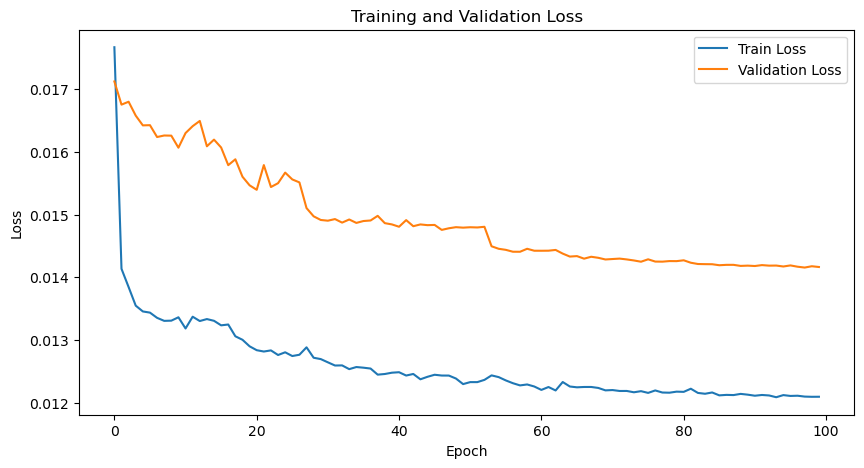

In [16]:
# train the model
model_uni_fintuned = nn.Sequential(
    nn.Linear(1536, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 460),
).to('cuda')

model_uni_fintuned, metrics_uni_finetuned = trainer.train_model(
    model_uni_fintuned,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='uni_finetuned_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)


In [38]:
# evaluate baseline on test set
model_uni_fintuned.eval()
model_uni_fintuned.to('cuda')
running_test_loss = 0.0
y_preds = []
y_trues = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_uni_fintuned(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

metrics_uni_finetuned['test_loss'] = test_loss
metrics_uni_finetuned['test_r2'] = r2_score
metrics_uni_finetuned['test_pearson'] = pearson_score

#Test Loss: 0.0136, R2: 0.7317, Pearson: 0.8539

Test Loss: 0.0136, R2: 0.7317, Pearson: 0.8539


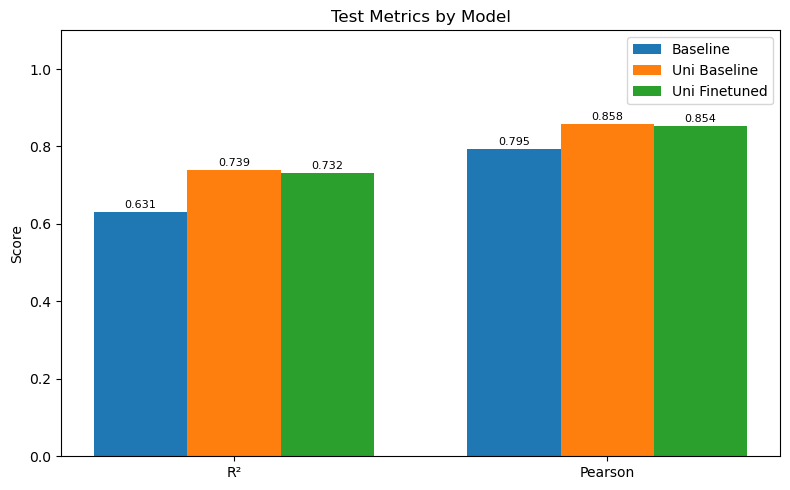

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['R²', 'Pearson']
models = ['Baseline', 'Uni Baseline', 'Uni Finetuned']
scores = [
    [metrics_baseline["test_r2"], metrics_baseline["test_pearson"]],
    [metrics_uni_baseline["test_r2"], metrics_uni_baseline["test_pearson"]],
    [metrics_uni_finetuned["test_r2"], metrics_uni_finetuned["test_pearson"]],
]
scores = np.array(scores)
x = np.arange(len(metrics)) 
plt.figure(figsize=(8, 5))
for i, (model, color) in enumerate(zip(models, ['C0', 'C1', 'C2'])):
    bar = plt.bar(x + i*0.25 - 0.25, scores[i], width=0.25, label=model, color=color)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height + 0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Test Metrics by Model')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()


### Results Visualization

In [22]:
# load pickle
with open(osp.expanduser("/home/b-evelyntong/hl/gutinstinct/data/processed/patch_to_expr_UC6_I.pkl"), "rb") as f:
    patch_list = pickle.load(f)
sdata = sd.read_zarr(osp.expanduser("/home/b-evelyntong/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr"))
he_img = sdata.images["HE_original"].data
he_img = np.transpose(he_img, (1, 2, 0))

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [4]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
model_uni.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [27]:
patch_transformed = [transform(patch['pil']) for patch in patch_list]
patch_tensor_stack = torch.stack(patch_transformed)
dataset = TensorDataset(patch_tensor_stack)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
model_uni.eval().to('cuda')
patch_tensors = []
with torch.no_grad():
    for batch in loader:
        x = batch[0].to('cuda')
        feats = model_uni(x).cpu()
        patch_tensors.append(feats)
patch_tensors = torch.cat(patch_tensors, dim=0)
expr_tensors = [torch.tensor(patch['expr'], dtype=torch.float32) for patch in patch_list]
dataset = TensorDataset(patch_tensors, torch.stack(expr_tensors), torch.arange(len(patch_list)))
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


# evaluate
model_uni_baseline.eval().to('cuda')
y_preds = []
indices = []

with torch.no_grad():
    for x_batch, y_batch, idx_batch in dataloader:
        x_batch = x_batch.to('cuda')
        y_pred = model_uni_baseline(x_batch)
        y_preds.append(y_pred.cpu())
        indices.append(idx_batch)

y_preds = torch.cat(y_preds, dim=0)
indices = torch.cat(indices, dim=0)

sorted_preds = y_preds[indices.argsort()].numpy()

In [ ]:
# let's pick a random gene
sdata['anucleus'].var['gene_symbols'][165]

/tmp/ipykernel_2729180/1756648787.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sdata['anucleus'].var['gene_symbols'][165]


'FOLR2'

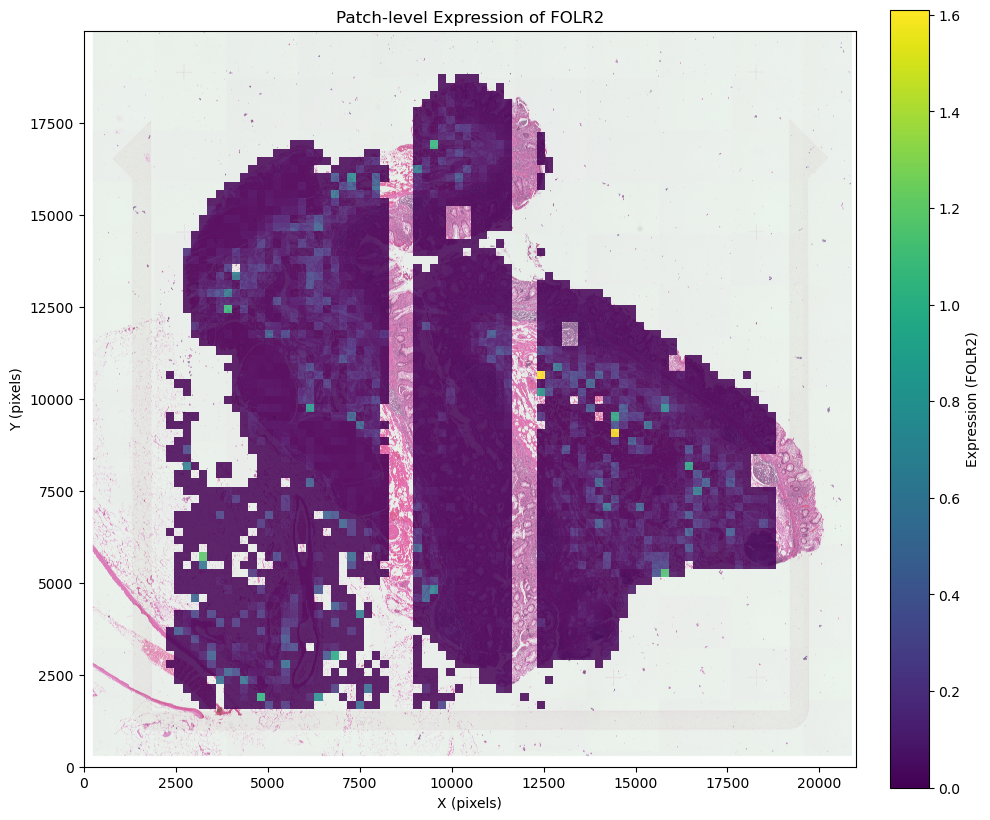

In [36]:
patch_size = 224

expression_vals = [patch['expr'][165] for patch in patch_list]
x_coords = [patch['patch_id'][1] * patch_size for patch in patch_list]
y_coords = [patch['patch_id'][0] * patch_size for patch in patch_list]

norm = plt.Normalize(min(expression_vals), max(expression_vals))
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(he_img, alpha=0.7)

for x, y, expr in zip(x_coords, y_coords, expression_vals):
    color = cmap(norm(expr))
    rect = patches.Rectangle((x, y), patch_size, patch_size, linewidth=0,
                             facecolor=color, alpha=0.85)
    ax.add_patch(rect)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Expression (FOLR2)')

ax.set_title("Patch-level Expression of FOLR2")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()

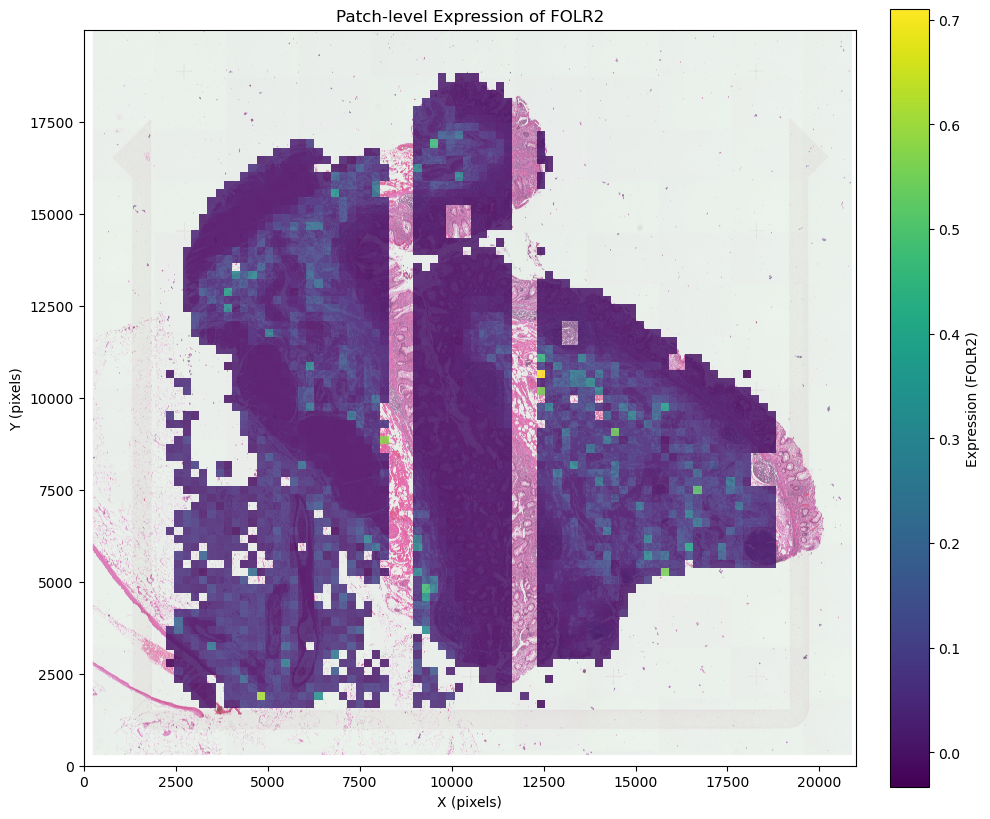

In [37]:
patch_size = 224

expression_vals = sorted_preds[:, 165]
x_coords = [patch['patch_id'][1] * patch_size for patch in patch_list]
y_coords = [patch['patch_id'][0] * patch_size for patch in patch_list]

norm = plt.Normalize(min(expression_vals), max(expression_vals))
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(he_img, alpha=0.7)

for x, y, expr in zip(x_coords, y_coords, expression_vals):
    color = cmap(norm(expr))
    rect = patches.Rectangle((x, y), patch_size, patch_size, linewidth=0,
                             facecolor=color, alpha=0.85)
    ax.add_patch(rect)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Expression (FOLR2)')

ax.set_title("Patch-level Expression of FOLR2")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()

# Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease \
Chen, R.J., Ding, T., Lu, M.Y. et al. Towards a general-purpose foundation model for computational pathology. Nat Med 30, 850–862 (2024). https://doi.org/10.1038/s41591-024-02857-3 \
Bunne, C., Stark, S.G., Gut, G. et al. Learning single-cell perturbation responses using neural optimal transport. Nat Methods 20, 1759–1768 (2023). https://doi.org/10.1038/s41592-023-01969-x \
Roohani, Y., Huang, K. & Leskovec, J. Predicting transcriptional outcomes of novel multigene perturbations with GEARS. Nat Biotechnol 42, 927–935 (2024). https://doi.org/10.1038/s41587-023-01905-6